In [33]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_data(image_dir, mask_dir):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '_mask.png'))
        
        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        
        images.append(image)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load the data
images, masks = load_data('Data/train/image', 'Data/train/mask')

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [34]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (64, 512, 512, 3)
y_train shape: (64, 512, 512)


In [35]:
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print("New y_train shape:", y_train.shape)

New y_train shape: (64, 512, 512, 1)


In [36]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_data(images, masks):
    images = images.astype('float32') / 255.0
    
    masks = (masks > 0).astype('float32')
    
    return images, masks

X_train, y_train = preprocess_data(X_train, y_train)
X_val, y_val = preprocess_data(X_val, y_val)

data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_generator = image_datagen.flow(X_train, seed=seed, batch_size=32)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32)

train_generator = zip(image_generator, mask_generator)

Image shape: (512, 512, 3)
Image data type: uint8
Image min and max values: 0 255
Mask shape: (512, 512)
Mask data type: uint8
Mask min and max values: 0 255


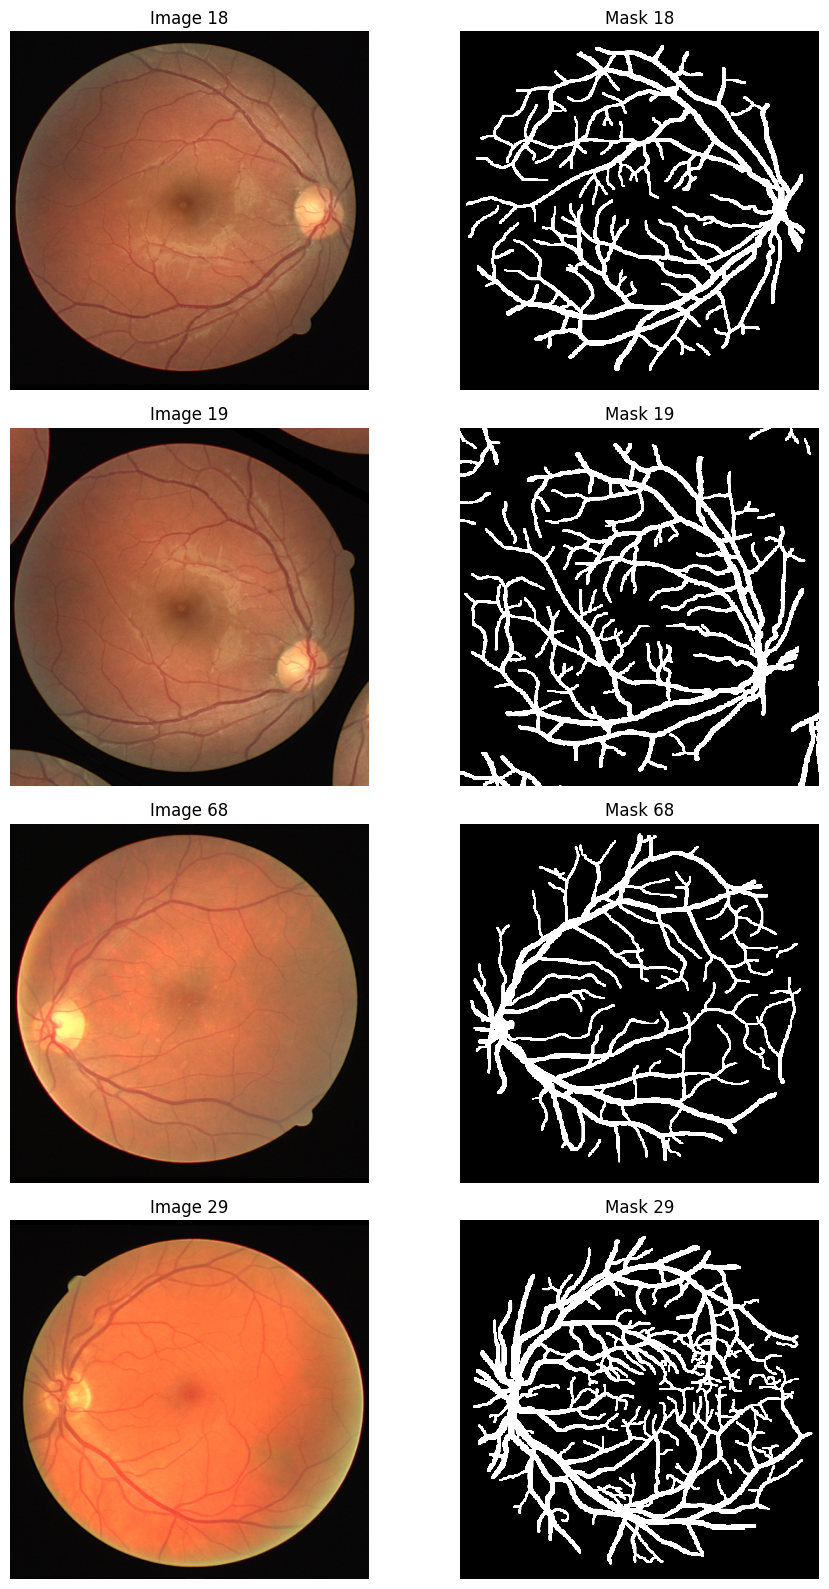

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_samples(images, masks, num_samples=4):
    indices = random.sample(range(len(images)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    
    for i, idx in enumerate(indices):
        img = images[idx]
        
        if len(img.shape) == 2:  # Grayscale
            axes[i, 0].imshow(img, cmap='gray')
        elif len(img.shape) == 3 and img.shape[2] == 3:  # RGB
            axes[i, 0].imshow(img)
        elif len(img.shape) == 3 and img.shape[2] == 1:  # Grayscale with channel dimension
            axes[i, 0].imshow(img[:,:,0], cmap='gray')
        else:
            print(f"Unexpected image shape for index {idx}: {img.shape}")
            continue
        
        axes[i, 0].set_title(f"Image {idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[idx], cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(f"Mask {idx}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Image shape:", images[0].shape)
print("Image data type:", images[0].dtype)
print("Image min and max values:", images[0].min(), images[0].max())

print("Mask shape:", masks[0].shape)
print("Mask data type:", masks[0].dtype)
print("Mask min and max values:", masks[0].min(), masks[0].max())

# Visualize samples
visualize_samples(images, masks)

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [40]:
def unet(input_size=(512, 512, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [41]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [42]:
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(y_true, y_pred):
    weight_for_0 = 1.0
    weight_for_1 = 8.0  # Adjust this based on your class imbalance
    y_true = K.clip(y_true, K.epsilon(), 1 - K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight_for_1 + 
                (1 - y_true) * K.log(1 - y_pred) * weight_for_0)
    return K.mean(logloss, axis=-1)

model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, metrics=['accuracy'])

In [43]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        pass  

In [44]:
train_generator = DataGenerator(X_train, y_train, batch_size=8)
val_generator = DataGenerator(X_val, y_val, batch_size=8)

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.keras', 
                    save_best_only=True, 
                    monitor='val_loss', 
                    mode='min', 
                    verbose=1),
    EarlyStopping(monitor='val_loss', 
                  patience=10, 
                  mode='min',
                  restore_best_weights=True, 
                  verbose=1),
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.1, 
                      patience=5, 
                      min_lr=1e-7, 
                      verbose=1)
]

In [46]:

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=5,
    callbacks=callbacks,
)

Epoch 1/5


/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8800 - loss: nan 
Epoch 1: val_loss did not improve from inf
8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 15s/step - accuracy: 0.8797 - loss: nan - val_accuracy: 0.8754 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 2/5


2024-07-13 15:45:45.401286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/miniconda3/envs/tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-13 15:45:45.411836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:


model = tf.keras.models.load_model('best_model.keras')

In [ ]:
test_images, test_masks = load_data('Data/test/image', 'Data/test/mask')
X_test, y_test = test_images, test_masks
X_test, y_test = preprocess_data(X_train, y_train)

test_generator = DataGenerator(X_test, y_test, batch_size=8)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.8785 - loss: nan
Test Loss: nan
Test Accuracy: 0.8772203922271729


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(test_generator)

y_pred_binary = (y_pred > 0.5).astype(int)

y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred_binary.reshape(-1)

cm = confusion_matrix(y_test_flat, y_pred_flat)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_flat))

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice = dice_coefficient(y_test, y_pred_binary)
print(f"\nDice Coefficient: {dice}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step
Confusion Matrix:
[[14717316        0]
 [ 2059900        0]]

Classification Report:


/opt/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93  14717316
         1.0       0.00      0.00      0.00   2059900

    accuracy                           0.88  16777216
   macro avg       0.44      0.50      0.47  16777216
weighted avg       0.77      0.88      0.82  16777216


Dice Coefficient: 0.0


/opt/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


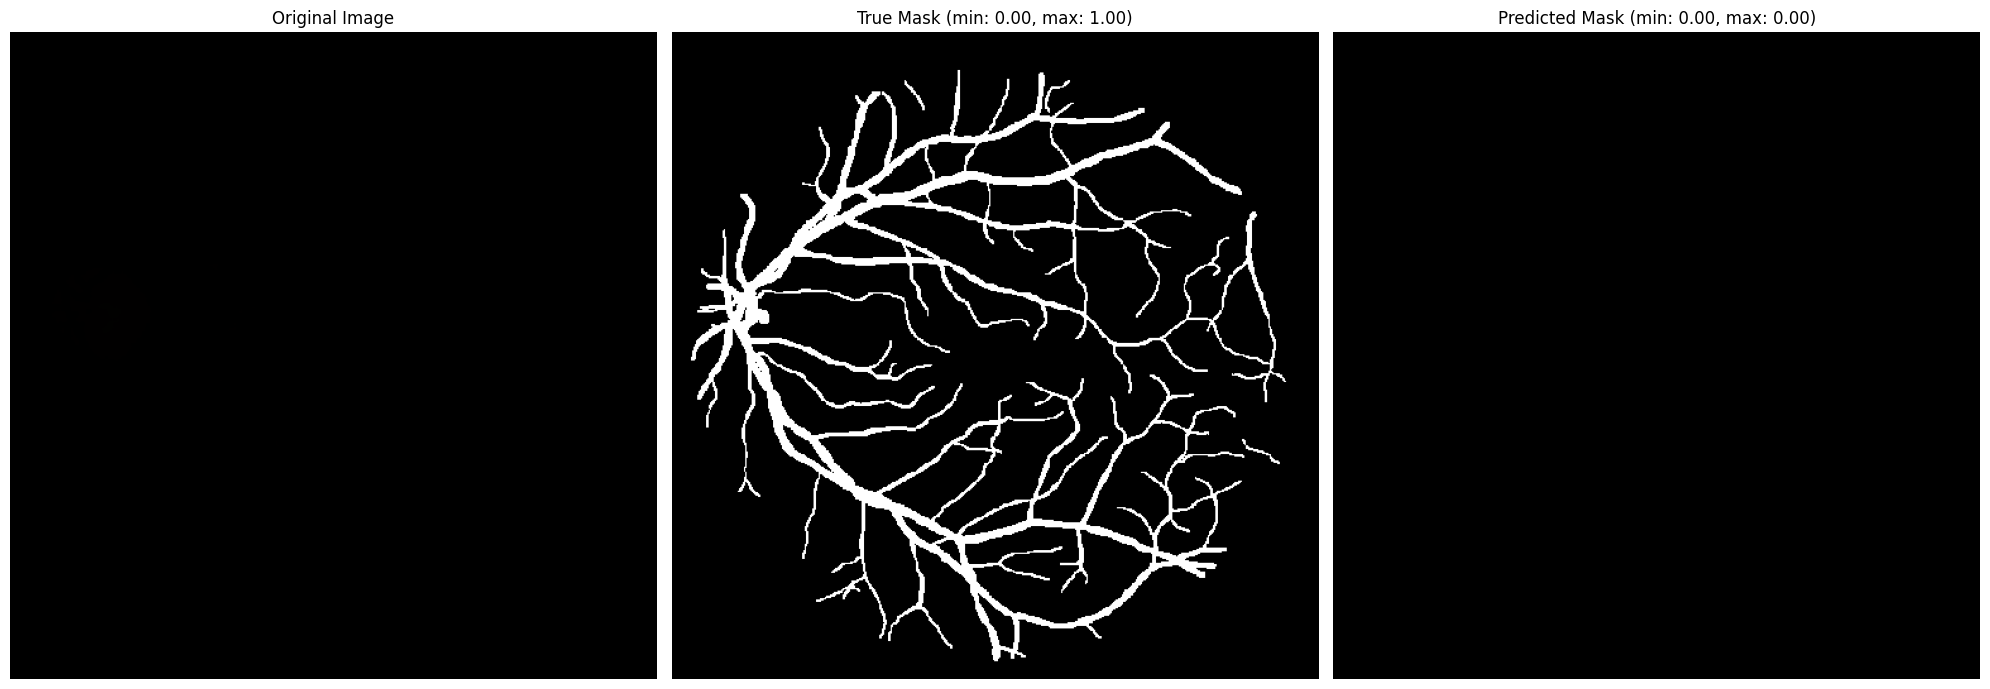

Image shape: (512, 512, 3)
True mask shape: (512, 512, 1)
Predicted mask shape: (512, 512, 1)
True mask unique values: [0. 1.]
Predicted mask unique values: [0]
---


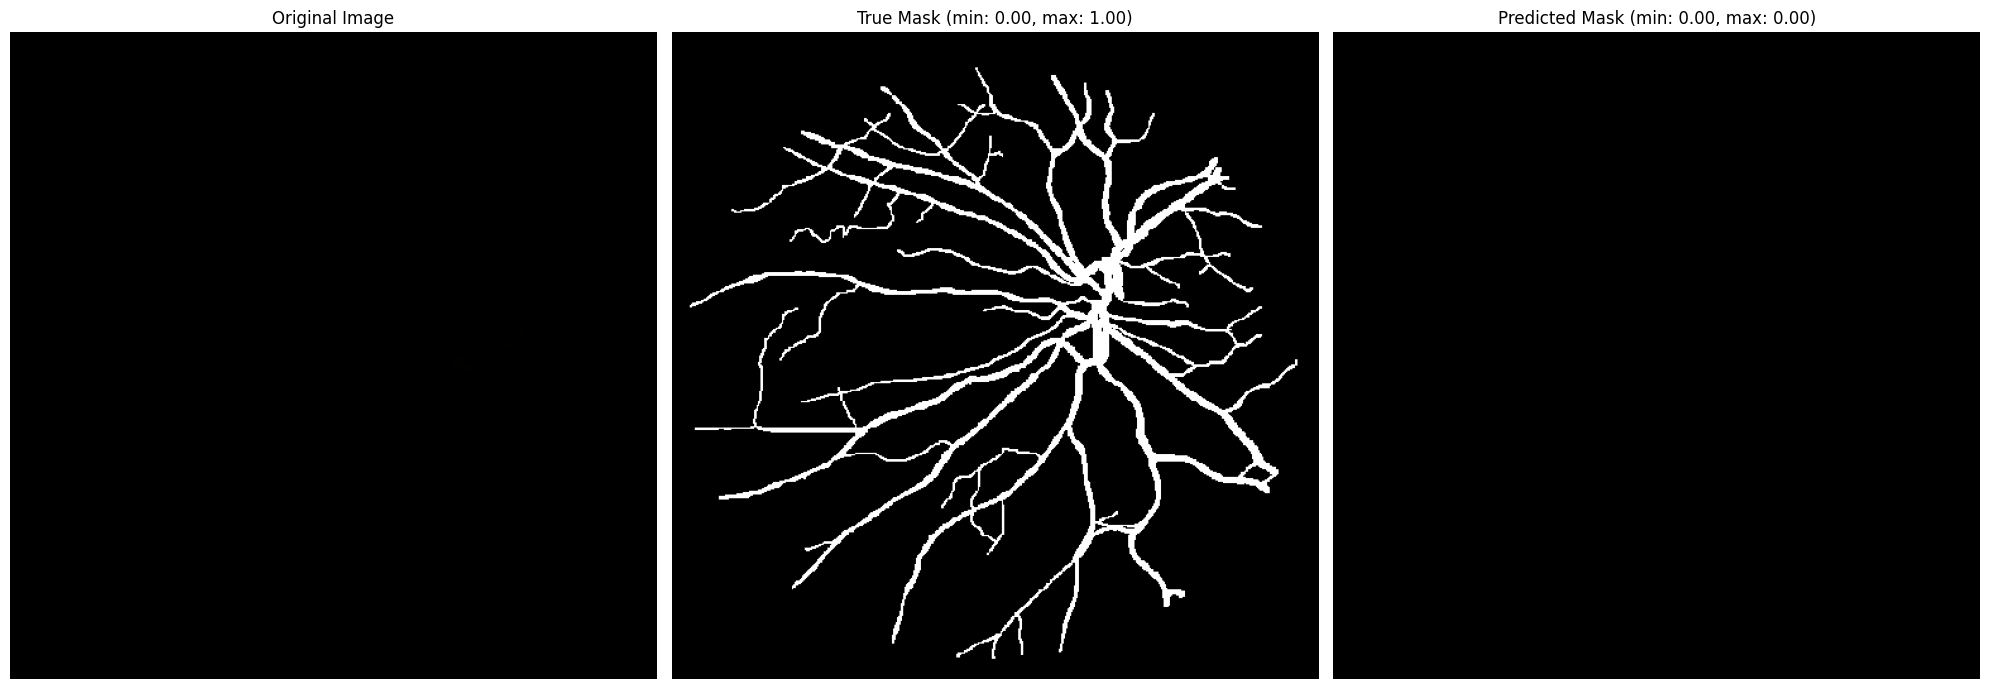

Image shape: (512, 512, 3)
True mask shape: (512, 512, 1)
Predicted mask shape: (512, 512, 1)
True mask unique values: [0. 1.]
Predicted mask unique values: [0]
---


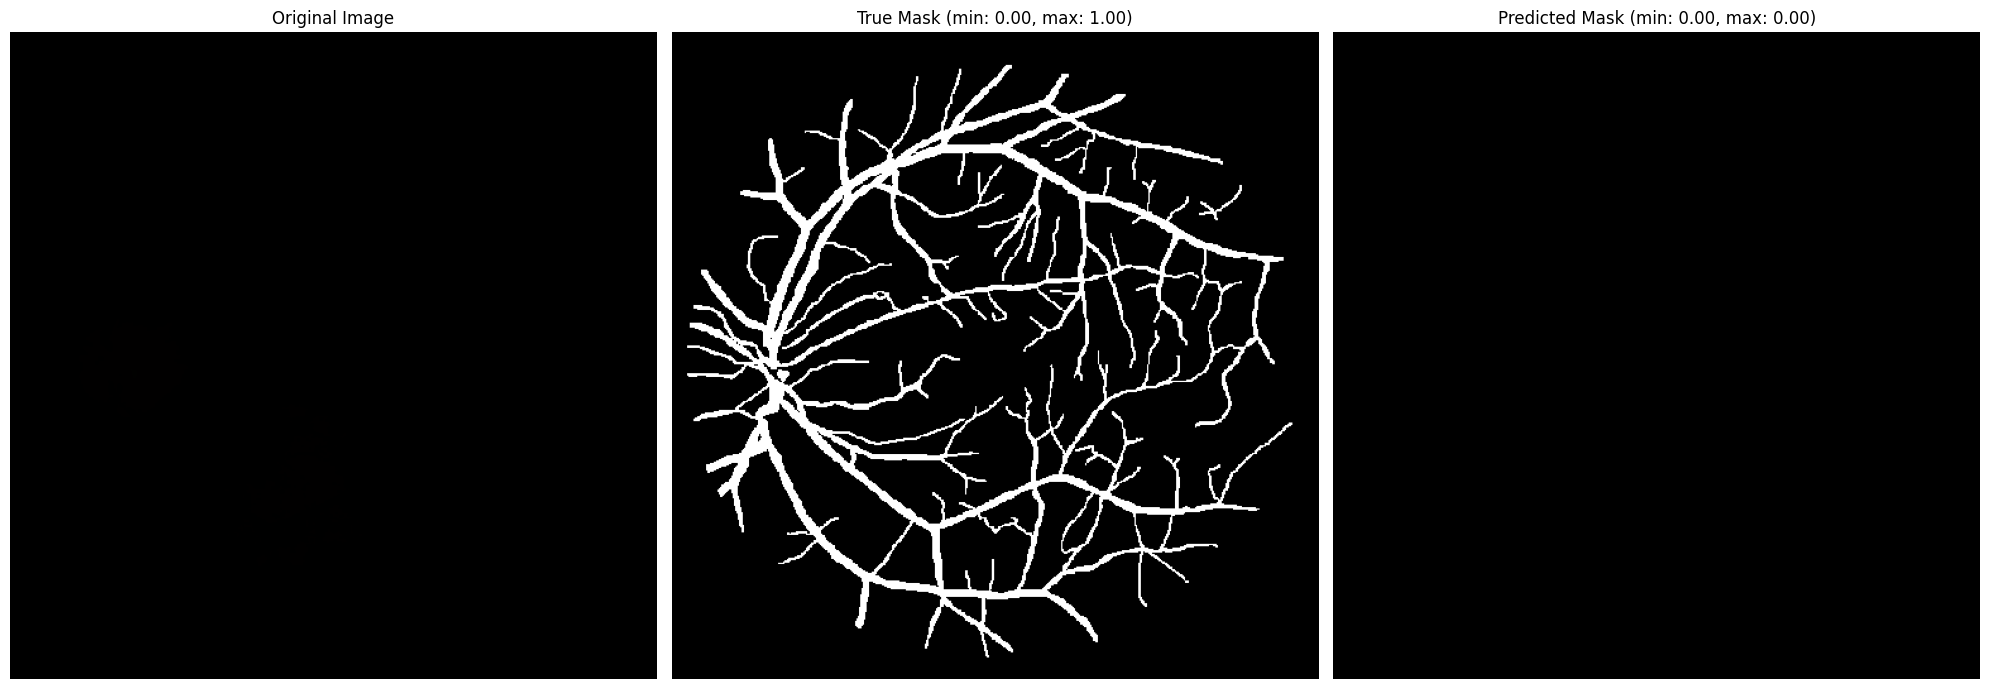

Image shape: (512, 512, 3)
True mask shape: (512, 512, 1)
Predicted mask shape: (512, 512, 1)
True mask unique values: [0. 1.]
Predicted mask unique values: [0]
---


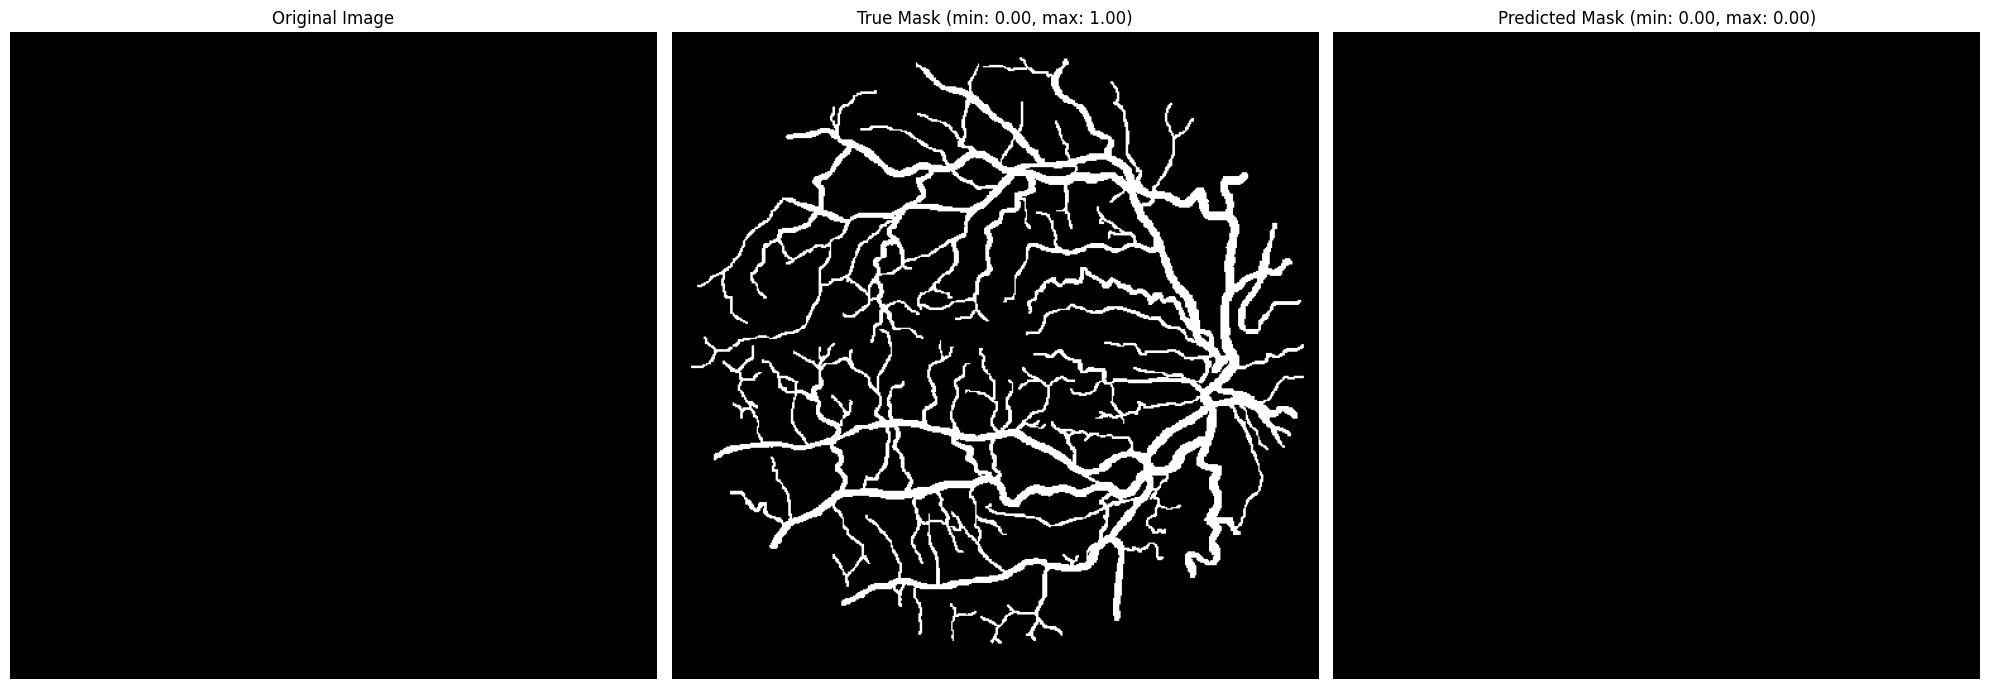

Image shape: (512, 512, 3)
True mask shape: (512, 512, 1)
Predicted mask shape: (512, 512, 1)
True mask unique values: [0. 1.]
Predicted mask unique values: [0]
---


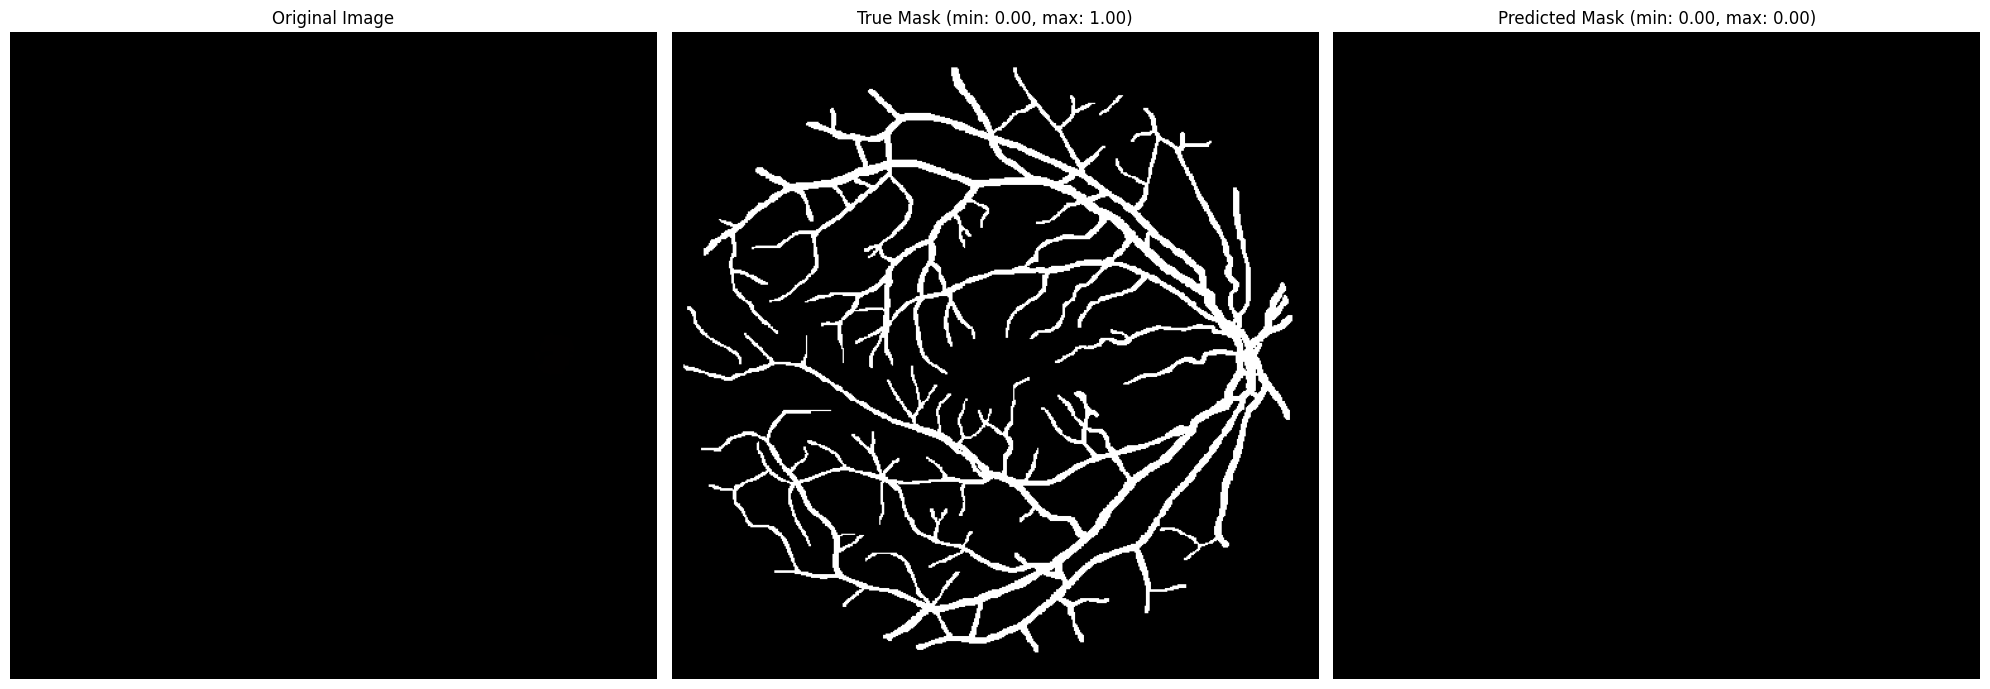

Image shape: (512, 512, 3)
True mask shape: (512, 512, 1)
Predicted mask shape: (512, 512, 1)
True mask unique values: [0. 1.]
Predicted mask unique values: [0]
---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    # Original Image
    if X[ix].shape[-1] == 1:  # Grayscale
        ax[0].imshow(X[ix].squeeze(), cmap='gray')
    else:  # RGB
        ax[0].imshow(X[ix])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # True Mask
    ax[1].imshow(y[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[1].set_title(f'True Mask (min: {y[ix].min():.2f}, max: {y[ix].max():.2f})')
    ax[1].axis('off')

    # Predicted Mask
    ax[2].imshow(preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    ax[2].set_title(f'Predicted Mask (min: {preds[ix].min():.2f}, max: {preds[ix].max():.2f})')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print additional information
    print(f"Image shape: {X[ix].shape}")
    print(f"True mask shape: {y[ix].shape}")
    print(f"Predicted mask shape: {preds[ix].shape}")
    print(f"True mask unique values: {np.unique(y[ix])}")
    print(f"Predicted mask unique values: {np.unique(preds[ix])}")
    print("---")

# Plot 5 random samples
for _ in range(5):
    plot_sample(X_test, y_test, y_pred_binary)